In [83]:
!pip install pytorch_lightning
!pip install pytorch_forecasting==0.8.2

In [84]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
import os
import warnings
warnings.filterwarnings("ignore")
pl.seed_everything(666)

666

In [85]:
df = pd.read_csv('Token-prices-avg-day.csv')
df

,date,price,date.1,month,day_of_week
0,2015-04-21,36250.375000,2015-04-21,4,1
1,2015-04-22,41571.255319,2015-04-22,4,2
2,2015-04-23,34058.500000,2015-04-23,4,3
3,2015-04-24,37422.458333,2015-04-24,4,4
4,2015-04-25,34447.492537,2015-04-25,4,5
...,...,...,...,...,...
2045,2021-01-11,162693.583333,2021-01-11,1,0
2046,2021-01-12,163558.319444,2021-01-12,1,1
2047,2021-01-13,161020.366197,2021-01-13,1,2
2048,2021-01-14,160985.666667,2021-01-14,1,3


In [86]:
data=pd.DataFrame()
data['price']=df.price.astype('float')
data['time_idx']=data.index
data['series']=0
data.head(10)

,price,time_idx,series
0,36250.375000,0,0
1,41571.255319,1,0
2,34058.500000,2,0
3,37422.458333,3,0
4,34447.492537,4,0
5,38888.300000,5,0
6,39143.232877,6,0
7,41298.718310,7,0
8,41633.686567,8,0
9,37958.070423,9,0


In [87]:
data.dtypes

price       float64
time_idx      int64
series        int64
dtype: object

In [88]:
day=1
max_prediction_length = day*7
max_encoder_length = 10
training_cutoff = data["time_idx"].max() - max_prediction_length
context_length = max_encoder_length
prediction_length = max_prediction_length

In [89]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["price"],
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    min_prediction_length=prediction_length,
    randomize_length=None,
    add_relative_time_idx=False,
    add_target_scales=False,
)

In [90]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [91]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.0154)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at C:\Users\Wilk96\Warcraft_price_prediction\lr_find_temp_model.ckpt

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params



suggested learning rate: 3.548133892335755e-05


1

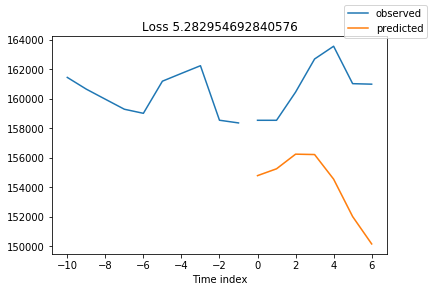

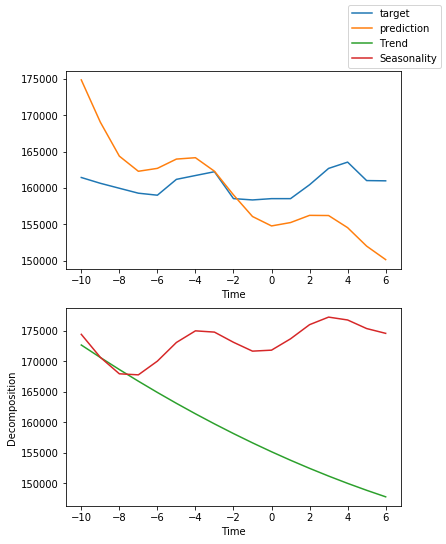

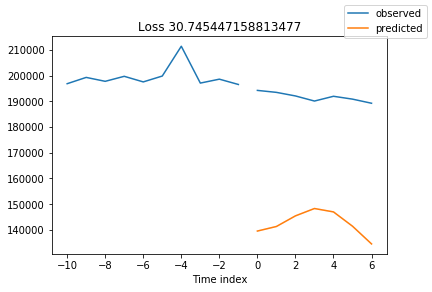

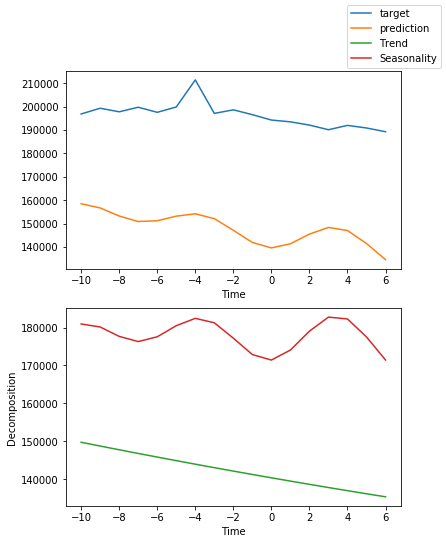

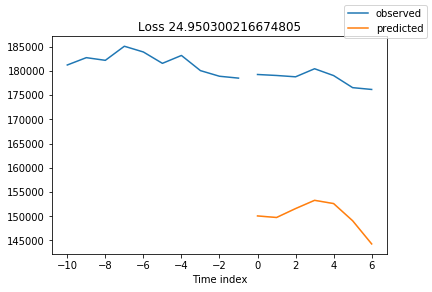

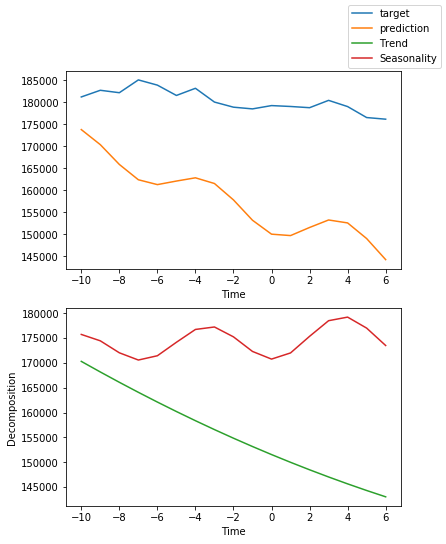

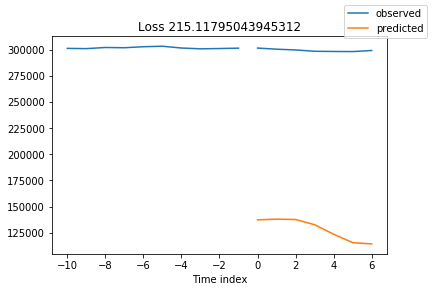

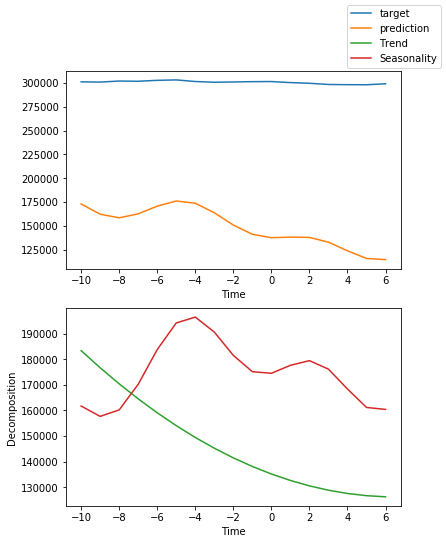

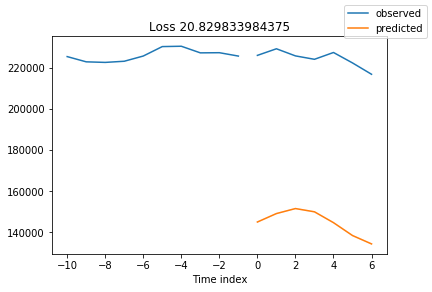

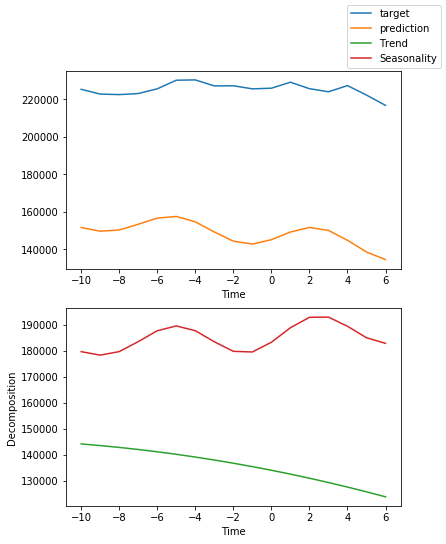

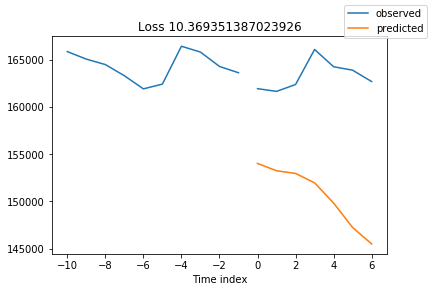

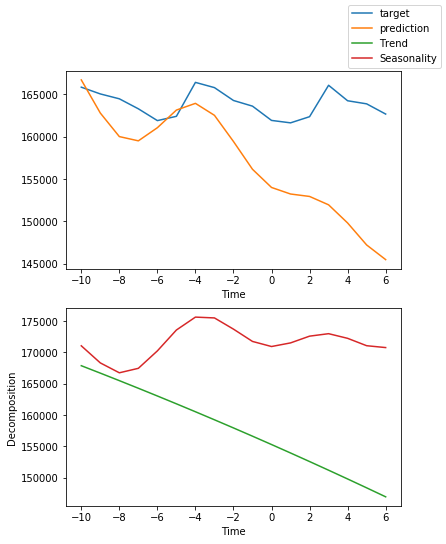

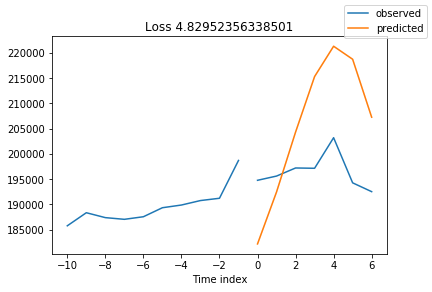

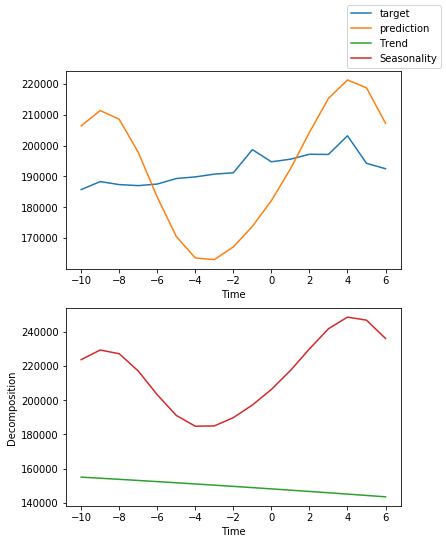

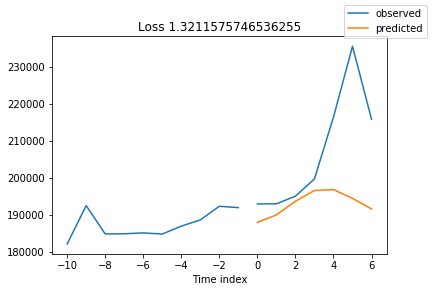

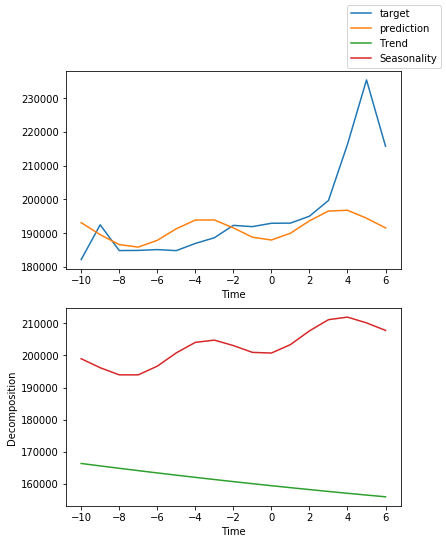

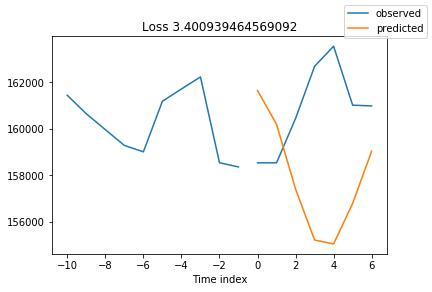

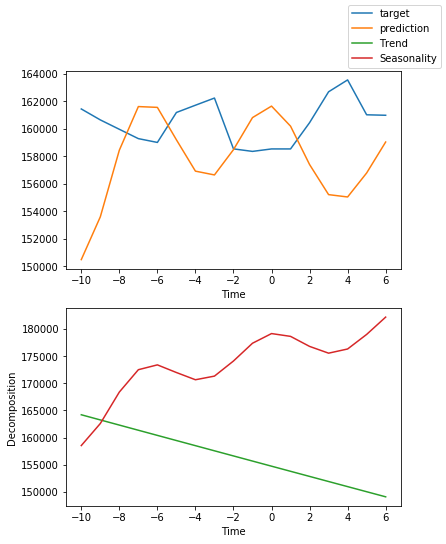

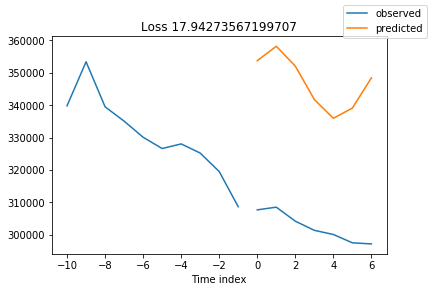

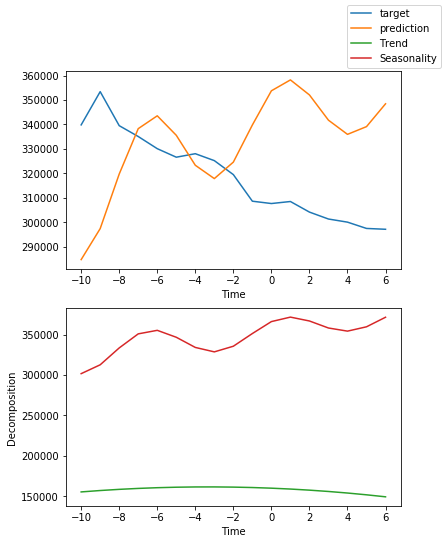

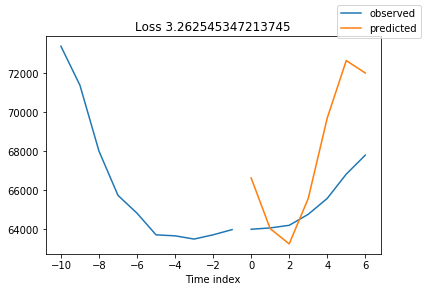

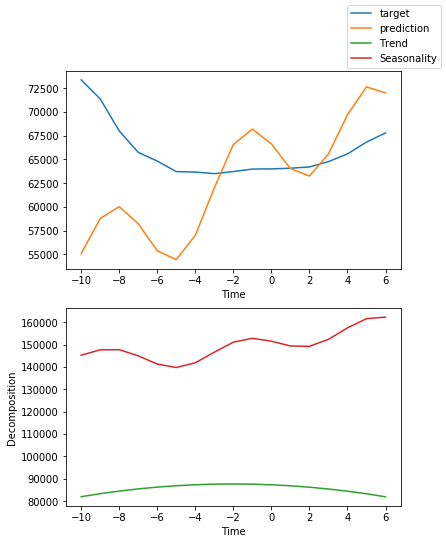

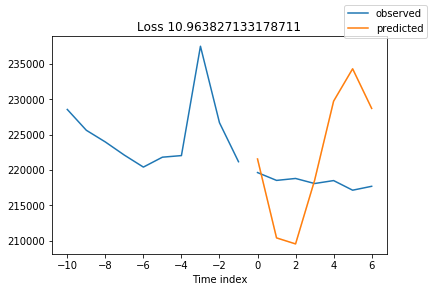

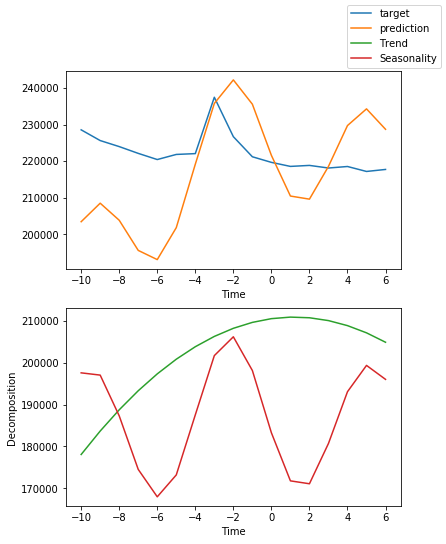

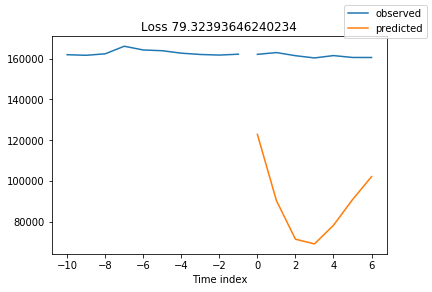

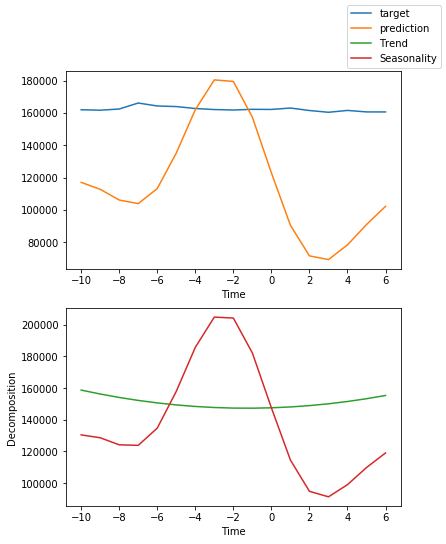

In [92]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    limit_train_batches=300,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
    #loss=MAE()
)
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
net.hparams.learning_rate = res.suggestion()
print(f"suggested learning rate: {res.suggestion()}")
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [93]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = net.predict(val_dataloader)
print((actuals - predictions).abs().mean())
print(SMAPE()(predictions, actuals))

tensor(2171.0872)
tensor(0.0135)


In [94]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True)


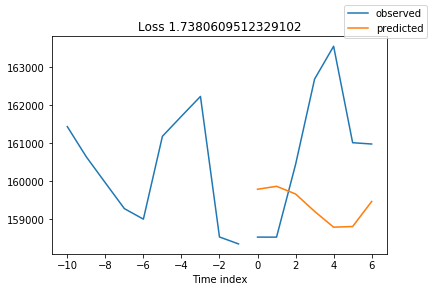

In [95]:
net.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

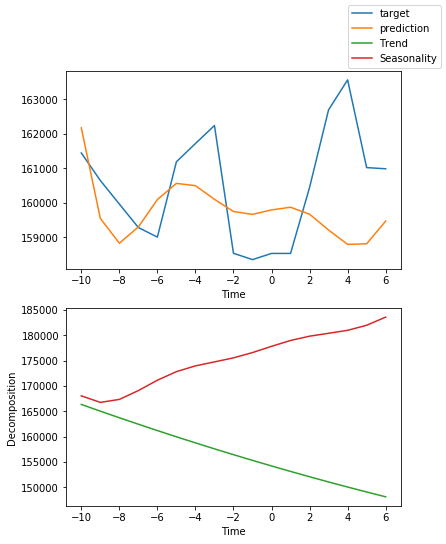

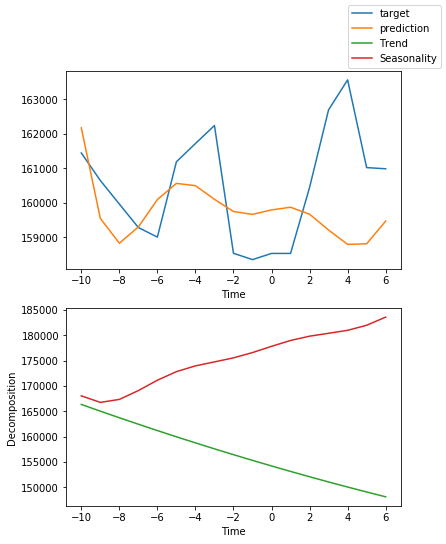

In [96]:
net.plot_interpretation(x, raw_predictions, idx=0)

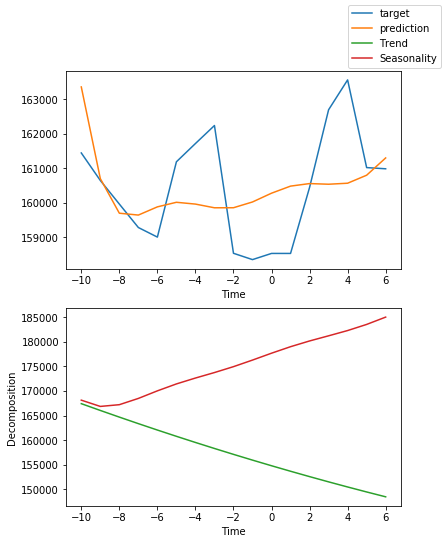

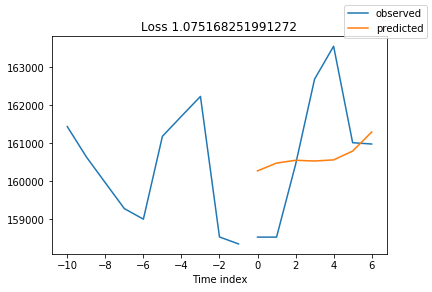

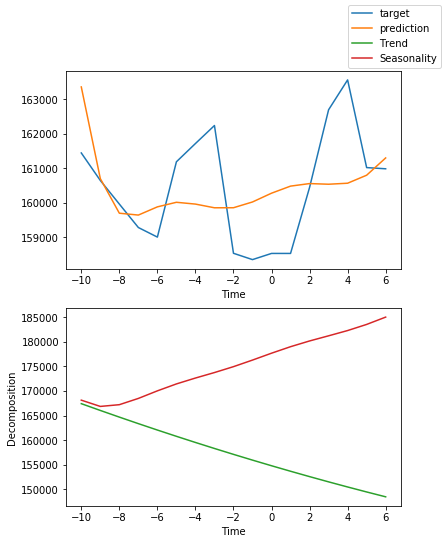

In [97]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);
best_model.plot_interpretation(x, raw_predictions, idx=0)